# Recommendation Systems

- **`Content Based Recommendation`**
  - Recommends items based on their characteristics and a user's preferences for those characteristics.
  - For example, a movie recommender might suggest films with similar genres or actors to ones a user has liked in the past.

- **`Collaborative Filtering`**
  - recommends items based on the preferences of similar users.
  - It doesn't require knowledge of the items themselves, just information about user interactions.
  - For example, a music streaming service might recommend songs that other users with similar tastes have enjoyed.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
mlxtend  : 0.23.1
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
from typing import Generator


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.
    """
    result: list[str] = []
    # Starts with a capital letter and then lowercase letters
    pattern: re.Pattern[str] = re.compile(r"^[A-Z][a-z]+")
    prod_id: str = ""

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        line: str = line.strip()
        if len(line.split(",")) == 1 and not pattern.match(line):
            prod_id = line
        elif pattern.match(line):
            result.append(f"{prod_id}: {line}")

    return result


def parse_keys_values(filename: str) -> Generator[dict[str, str], None, None]:
    """
    Parse key-value pairs from a file.

    Parameters
    ----------
    filename : str
        The path to the file to be parsed.

    Yields
    ------
    dict[str, str]
        A dictionary containing key-value pairs parsed from the file.

    """
    entry: dict[str, str] = {}
    f = open(filename, "rb")

    # Iterate over all lines in the file.
    for l in f:
        l = l.strip()
        # The key/value pairs are separated by a colon.
        colonPos: int = l.find(b":")
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        key: str = l[:colonPos].decode("latin-1")
        value: str = l[colonPos + 2 :].decode("latin-1")
        entry[key] = value
    yield entry


def read_reviews(path: str, num: int = -1) -> pl.DataFrame:
    """
    Read reviews from a file and return them as a Polars DataFrame.

    Parameters
    ----------
    path : str
        The path to the file containing the reviews.
    num : int, optional
        The number of reviews to read. If -1, read all reviews. Default is -1.

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing the parsed reviews.

    """
    i: int = 0
    df: dict[int, dict[str, str]] = {}
    for d in parse_keys_values(path):
        df[i] = d
        i += 1
        if i == num:
            break
    result: pl.DataFrame = pl.DataFrame([x for x in df.values()])
    return result

In [4]:
fp: str = "../../data/prod_categories.parquet"

prod_categories: pl.DataFrame = pl.read_parquet(fp)
print(f"{prod_categories.shape = }")
prod_categories.head(3)

prod_categories.shape = (2437878, 2)


product_id,product_category
str,str
"""B00005AL88""","""Cookware, Cookware Sets, Kitchen & Dining, Home & Kitchen"""
"""B000002ERS""","""Music, World Music Music, Latin Music"""
"""B000PR126O""","""Jewelry, Charms"""


In [5]:
# Set verbosity level
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [6]:
fp: str = "../../data/Music_small.parquet"
df_music: pl.DataFrame = pl.read_parquet(fp).sample(
    fraction=0.3, shuffle=True, seed=123
)
print(f"{df_music.shape = }")
df_music.head(2)

df_music.shape = (1918905, 10)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004VVN6""","""Elvis - '68 Comeback Special (1968)""","""unknown""","""A1VMEBPPFUU0J7""","""C. Manson""","""1/1""",5.0,"""960595200""","""No Strap for You""","""I could easily slobber all over my blue suede shoes praising this one, but let me just sum it up by…"
"""B000003BD7""","""A Christmas Gift for You from Phil Spector""","""12.14""","""A13HAJYO0FO0LQ""","""Aj Watson""","""3/5""",5.0,"""1258416000""","""Great in mono""","""My copy of Sony's remaster of this Xmas classic arrived today. I have to say, this 2009 remaster fr…"


### Data Cleaning

In [7]:
df_music.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004VVN6""","""Elvis - '68 Comeback Special (1968)""","""unknown""","""A1VMEBPPFUU0J7""","""C. Manson""","""1/1""",5.0,"""960595200""","""No Strap for You""","""I could easily slobber all over my blue suede shoes praising this one, but let me just sum it up by…"
"""B000003BD7""","""A Christmas Gift for You from Phil Spector""","""12.14""","""A13HAJYO0FO0LQ""","""Aj Watson""","""3/5""",5.0,"""1258416000""","""Great in mono""","""My copy of Sony's remaster of this Xmas classic arrived today. I have to say, this 2009 remaster fr…"
"""B000AMUUSU""","""Hello Waveforms""","""unknown""","""A2X192PNI73QWI""","""David L. Reade""","""0/5""",5.0,"""1131408000""","""You are absolutely right.....""","""I'm referring to the comments of the first reviewer, he's right: what's up with Orbit's website not…"
"""B00000EGZR""","""About Face""","""unknown""","""A1P6559HS6RN6""","""Dustbuny48 ""Music Soul""""","""2/2""",4.0,"""1189296000""","""A most wonderful surprise""","""While most modern day Pink Floyd fans only know David Gilmour as a major contributor to their later…"
"""B0000013GH""","""Secrets""","""11.98""","""A105NYRPZGNJ19""","""F. Juergens""","""3/17""",2.0,"""1046217600""","""Overrated!""","""To me, Toni Braxton is one of the most overrated singers of the 90s, and this album is far worse th…"


In [8]:
# Check for unique product and userId entries
p_id: str = "B000058A81"
user_id: str = "A18C9SNLZWVBIE"
df_music.filter((pl.col("productId").eq(p_id) & pl.col("userId").eq(user_id)))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str


In [9]:
# We want a:
# unique user-product pair.
# unique user-title pair.
# unique product-title pair.

print(f"[Before data cleaning]: {df_music.shape}")

# Remove duplicates
df_music_cleaned: pl.DataFrame = df_music.unique(subset=["userId", "productId"])
# df_music_cleaned = df_music_cleaned.unique(subset=["userId", "title"])
# df_music_cleaned = df_music_cleaned.unique(subset=["productId", "title"])

print(f"[After data cleaning]: {df_music_cleaned.shape}")

[Before data cleaning]: (1918905, 10)
[After data cleaning]: (1638866, 10)


In [10]:
df_music_cleaned.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00000E4HA""","""Handel: Israel in Egypt""","""unknown""","""A70WPHE33U5B""","""Kirk List ""KV503""""","""1/1""",5.0,"""1353974400""","""An exciting choral feast""","""Charles Mackerras was a superb Handel conductor, recording oratorios such as Israel in Egypt, Judas…"
"""B000005B0J""","""Turn the Radio Off""","""unknown""","""AX3LZO32C0JFA""","""thomas""","""0/0""",5.0,"""966124800""","""this cd rocks""","""this cd is da bomb buy it buy it"""
"""0970348002""","""Rope Around The World [VHS]""","""unknown""","""unknown""","""unknown""","""1/1""",5.0,"""980985600""","""Aerobic exercise in funtime.""","""Watching this fun way to exercise this 75 year old male wanted to run right out and get a jump rope…"
"""B000OCXMAE""","""Minutes to Midnight""","""10.99""","""A25K3Q88LRP5KU""","""Syp""","""3/7""",5.0,"""1179878400""","""A Departure, but its still LP""","""Linkin Park's latest album is an intentional departure from their older sound. At least...they try …"
"""B000093W39""","""Loveless [Vinyl]""","""unknown""","""A370T7ZOJJ76I2""","""fluffy, the human being.""","""10/11""",4.0,"""1174003200""","""4 1/2""","""this album is a regular on greatest albums of all-time lists that i see. upon first listen i hated …"


In [11]:
# Check the unique userIDs
df_music_cleaned["userId"].value_counts(sort=True).head()

userId,count
str,u32
"""unknown""",109297
"""A9Q28YTLYREO7""",3097
"""A2WQY1B8ZS7QRZ""",1534
"""A8IFUOL8S9BZC""",1529
"""A2U49LUUY4IKQQ""",1356


In [12]:
# Check the unique title
df_music_cleaned["title"].value_counts(sort=True).head(20)

title,count
str,u32
"""Greatest Hits""",6031
"""Best of""",3488
"""St. Anger""",2869
"""Kind of Blue""",2734
"""Hybrid Theory""",2576
"""No Strings Attached""",2251
"""Come Away With Me""",2110
"""Let Go""",1756
"""Fallen""",1736


In [13]:
# Drop the unwanted userIDs
rem_str: str = "unknown"
rem_str_2: str = ""
print(f"[Before data cleaning]: {df_music_cleaned.shape}")
df_music_cleaned = df_music_cleaned.filter(pl.col("userId").ne(rem_str))
df_music_cleaned = df_music_cleaned.filter(pl.col("title").ne(rem_str_2))
print(f"[After data cleaning]: {df_music_cleaned.shape}")

[Before data cleaning]: (1638866, 10)
[After data cleaning]: (1529158, 10)


In [14]:
df_music_cleaned.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00000E4HA""","""Handel: Israel in Egypt""","""unknown""","""A70WPHE33U5B""","""Kirk List ""KV503""""","""1/1""",5.0,"""1353974400""","""An exciting choral feast""","""Charles Mackerras was a superb Handel conductor, recording oratorios such as Israel in Egypt, Judas…"
"""B000005B0J""","""Turn the Radio Off""","""unknown""","""AX3LZO32C0JFA""","""thomas""","""0/0""",5.0,"""966124800""","""this cd rocks""","""this cd is da bomb buy it buy it"""
"""B000OCXMAE""","""Minutes to Midnight""","""10.99""","""A25K3Q88LRP5KU""","""Syp""","""3/7""",5.0,"""1179878400""","""A Departure, but its still LP""","""Linkin Park's latest album is an intentional departure from their older sound. At least...they try …"
"""B000093W39""","""Loveless [Vinyl]""","""unknown""","""A370T7ZOJJ76I2""","""fluffy, the human being.""","""10/11""",4.0,"""1174003200""","""4 1/2""","""this album is a regular on greatest albums of all-time lists that i see. upon first listen i hated …"
"""B00004W5AX""","""For All Seasons""","""unknown""","""A10DNEWBQVGJNP""","""Abstract Analyst""","""0/0""",4.0,"""1053388800""","""Possibly, hip-hop's most underrated album.""","""Amazon.com really needs to incorporate the half a star rating tiers. Nature's For All Seaons is a f…"


In [15]:
# Check the unique titles
# df_music_cleaned["title"].value_counts(sort=True).slice(20, 40)
titles: list[dict[str, int]] = (
    df_music_cleaned["title"].value_counts(sort=True).to_dicts()
)
titles = sorted(titles, key=lambda x: x["title"], reverse=True)
titles[980:1000]

[{'title': 'Yundi Li: Vienna Recital - Scarlatti / Mozart / Schumann / Liszt',
  'count': 5},
 {'title': 'Yundi Li: Live in Concert (2005)', 'count': 7},
 {'title': 'Yunagi Loop', 'count': 1},
 {'title': 'Yummy, Yummy, Yummy', 'count': 5},
 {'title': 'Yummy Yummy: Best of Bubble Gum Music', 'count': 1},
 {'title': 'Yummy Yummy Yummy', 'count': 1},
 {'title': 'Yummy Yummy (Blister)', 'count': 22},
 {'title': 'Yummy Yummy', 'count': 57},
 {'title': 'Yummy', 'count': 1},
 {'title': "Yumeji's Theme", 'count': 1},
 {'title': 'Yume No Oka', 'count': 1},
 {'title': 'Yume Bitsu', 'count': 1},
 {'title': 'Yuletunes', 'count': 2},
 {'title': 'Yuletide in the Shire', 'count': 4},
 {'title': 'Yuletide Joy', 'count': 4},
 {'title': 'Yuletide Guitars', 'count': 1},
 {'title': 'Yuletide Guitar', 'count': 1},
 {'title': 'Yuletide Fires', 'count': 1},
 {'title': 'Yuletide Classics', 'count': 2},
 {'title': 'Yulesville', 'count': 1}]

In [16]:
text: str = "zoo rave"
df_music_cleaned.filter(pl.col("title").str.to_lowercase().str.contains(text))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00000099A""","""Zoo Rave II""","""unknown""","""A3010KGHW804ZD""","""Craig Froehle""","""1/1""",3.0,"""980035200""","""Typical dance techno -- not bad, not great""","""This disc was published by BMG records and all tracks were produced by the artists specifically for…"
"""B00000099A""","""Zoo Rave II""","""unknown""","""A1DTAWBG9UTVWR""","""""mn2nmixr""""","""2/2""",5.0,"""1015200000""","""Perfecto""","""First of all, this album is from 1993, so late 90's is impossible. A great album packed with a vari…"
"""B00000098Q""","""Zoo Rave, Vol. 1 [Vinyl]""","""unknown""","""A1SFF3DSLJVIEW""","""Ross H. Goodwin ""Digitally Natured Audio""""","""5/5""",5.0,"""1136678400""","""Nostalgic Frequencies....""","""I originally bought this as a cassette in 93. Back then I loved every moment of the cd, in retrospe…"
"""B00000E9GW""","""Zoo Rave 2""","""2.99""","""A1DTAWBG9UTVWR""","""""mn2nmixr""""","""2/2""",5.0,"""1015200000""","""Perfecto""","""First of all, this album is from 1993, so late 90's is impossible. A great album packed with a vari…"
"""B00000E9GW""","""Zoo Rave 2""","""2.99""","""A3F6L8ANIGHCAV""","""B. Lynch ""the_onewhoknows""""","""1/2""",5.0,"""981590400""","""Worth seeking out""","""While the tunes here are all from the mid to late 1990's, they were cutting-edge in nearly any sens…"


### Apply Levenshtein Distance

- Levenshtein Distance is a string metric used to measure the difference between two sequences.
- It calculates the `minimum number of single-character edits` (`insertions`, `deletions`, or `substitutions`) required to change one word into another.
- It provides a quantitative measure of how dissimilar two strings are, which can be very useful in recommendation systems, especially for handling `typos` or `slight variations` in text input.
- It's an effective way to find close matches even when there are small differences between strings.

In [17]:
def levenshtein_distance(s1: str, s2: str) -> int:
    """
    Calculate the Levenshtein distance between two strings.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    int
        The Levenshtein distance between s1 and s2.

    Example
    -------
    >>> levenshtein_distance("kitten", "sitting")
    3
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row: list[int] = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row: list[int] = [i + 1]
        for j, c2 in enumerate(s2):
            insertions: int = previous_row[j + 1] + 1
            deletions: int = current_row[j] + 1
            substitutions: int = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def compute_string_similarity(s1: str, s2: str) -> float:
    """
    Compute the similarity between two strings based on Levenshtein distance.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    float
        A similarity score between 0 and 1, where 1 indicates identical strings.
    """
    distance: int = levenshtein_distance(s1, s2)
    max_length: int = max(len(s1), len(s2))
    similarity: float = 1 - (distance / max_length)
    return round(similarity, 4)

In [18]:
s1, s2 = "friend", "fiend"
distance: int = levenshtein_distance(s1=s1, s2=s2)
print(f"{distance = }")

similarity: float = compute_string_similarity(s1=s1, s2=s2)
print(f"{similarity = }")

distance = 1
similarity = 0.8333


In [19]:
temp_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": [
            "spider man",
            "Spider-Man",
            "Spiderman",
            "Anikulapo",
            "Aniku la po",
        ],
        "ratings": [5, 5, 4, 3, 3],
    }
)
temp_df

title,ratings
str,i64
"""spider man""",5
"""Spider-Man""",5
"""Spiderman""",4
"""Anikulapo""",3
"""Aniku la po""",3


In [20]:
temp_df = temp_df.with_columns(title=pl.col("title").str.to_lowercase())
uniq_titles: list[str] = temp_df["title"].unique().to_list()
schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
similarity_df: pl.DataFrame = pl.DataFrame(schema=schema)
similarity_df

title_1,title_2,similarity
str,str,f32


In [21]:
# Calculate similarity

result: list[dict[str, Any]] = []
threshold: float = 0.8

for idx, title_ in enumerate(uniq_titles):
    for n_title_ in uniq_titles[idx + 1 :]:
        score: float = compute_string_similarity(title_, n_title_)
        if score >= threshold:
            result.append({"title_1": title_, "title_2": n_title_, "similarity": score})
d: pl.DataFrame = pl.DataFrame(result, schema=schema)
similarity_df = pl.concat([similarity_df, d]).sort(by="title_1", descending=False)
similarity_df

title_1,title_2,similarity
str,str,f32
"""aniku la po""","""anikulapo""",0.8182
"""spider man""","""spiderman""",0.9
"""spider-man""","""spider man""",0.9
"""spider-man""","""spiderman""",0.9


In [22]:
def compute_similarity_matrix(
    unique_titles: list[str], threshold: float = 0.8
) -> pl.DataFrame:
    """
    Compute similarity matrix for unique titles.

    Parameters
    ----------
    unique_titles : list[str]
        List of unique titles to compare.
    threshold : float, optional
        Similarity threshold for including pairs, by default 0.8.

    Returns
    -------
    pl.DataFrame
        DataFrame containing similarity scores for title pairs above the threshold.
    """
    schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
    result: list[dict[str, Any]] = []

    for idx, title_ in enumerate(unique_titles):
        for n_title_ in unique_titles[idx + 1 :]:
            score: float = compute_string_similarity(title_, n_title_)
            if score >= threshold:
                result.append(
                    {"title_1": title_, "title_2": n_title_, "similarity": score}
                )

    d: pl.DataFrame = pl.DataFrame(result, schema=schema)
    similarity_df: pl.DataFrame = pl.DataFrame(data=d, schema=schema).sort(
        by="title_1", descending=False
    )
    return similarity_df

In [23]:
def create_title_mapping(similarity_list: list[dict[str, str]]) -> dict[str, str]:
    """
    Create a mapping of variant titles to their canonical forms.

    Parameters
    ----------
    similarity_list : list[dict[str, str]]
        A list of dictionaries, where each dictionary contains
        'title_1' and 'title_2' keys with string values.

    Returns
    -------
    dict[str, str]
        A dictionary mapping variant titles to their canonical forms.

    Notes
    -----
    The canonical form is chosen as the shorter of the two titles.
    """
    mapping: dict[str, str] = {}

    for item in similarity_list:
        title_1: str = item["title_1"]
        title_2: str = item["title_2"]

        # Choose the shorter title as the canonical form
        if len(title_1) <= len(title_2):
            canonical: str = title_1
            variant: str = title_2
        else:
            canonical: str = title_2
            variant: str = title_1

        mapping[variant] = canonical

    return mapping


def replace_similar(title: str, mapping: dict[str, str]) -> str:
    return mapping.get(title, title)

In [24]:
similarity_df: pl.DataFrame = compute_similarity_matrix(
    unique_titles=uniq_titles, threshold=0.75
)
similarity_df

title_1,title_2,similarity
str,str,f32
"""aniku la po""","""anikulapo""",0.8182
"""spider man""","""spiderman""",0.9
"""spider-man""","""spider man""",0.9
"""spider-man""","""spiderman""",0.9


In [25]:
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

{'aniku la po': 'anikulapo',
 'spider man': 'spider-man',
 'spider-man': 'spiderman'}

In [26]:
# Apply the replacement to the DataFrame
temp_df = temp_df.with_columns(
    title=pl.col("title").map_elements(
        lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8
    )
)
temp_df

title,ratings
str,i64
"""spider-man""",5
"""spiderman""",5
"""spiderman""",4
"""anikulapo""",3
"""anikulapo""",3


#### Apply To the Data

In [27]:
# df_music_cleaned.write_parquet("music_data_vsm.parquet")

# Load similarities
similarity_df: pl.DataFrame = pl.read_csv("similar_titles.csv")
similarity_df.head()

title_1,title_2,similarity
str,str,f64
"""""Barry Manilow - Greatest Hits, Vol. 2""""","""Barry Manilow - Greatest Hits, Vol. 2""",0.9297
"""""Buck Owens - All-Time Greatest Hits, Vol.2""""","""""Buck Owens - All-Time Greatest Hits, Vol.1""""",0.9023
"""""Neil Norman - Greatest Science Fiction Hits, Vol. 1""""","""Neil Norman - Greatest Science Fiction Hits, Vol. 3""",0.9297
"""""Neil Norman - Greatest Science Fiction Hits, Vol. 2""""","""""Neil Norman - Greatest Science Fiction Hits, Vol. 1""""",0.9414
"""""New Hawaiian Band - Hawaii's Greatest Hits, Vol. 1""""","""""New Hawaiian Band - Hawaii's Greatest Hits, Vol. 2""""",0.9453


In [28]:
similarity_df.describe()

statistic,title_1,title_2,similarity
str,str,str,f64
"""count""","""33070""","""33070""",33070.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,0.991223
"""std""",null,null,0.023652
"""min""","""""Barry Manilow - Greatest Hits, Vol. 2""""","""""Buck Owens - All-Time Greatest Hits, Vol.1""""",0.9023
"""25%""",null,null,1.0
"""50%""",null,null,1.0
"""75%""",null,null,1.0
"""max""","""y""","""y""",1.0


In [29]:
print("[INFO]: Creating title mapping")
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

[INFO]: Creating title mapping


{'"Barry Manilow - Greatest Hits, Vol. 2"': 'Barry Manilow - Greatest Hits, Vol. 2',
 '"Buck Owens - All-Time Greatest Hits, Vol.1"': '"Buck Owens - All-Time Greatest Hits, Vol.2"',
 '"Neil Norman - Greatest Science Fiction Hits, Vol. 1"': '"Neil Norman - Greatest Science Fiction Hits, Vol. 2"',
 '"New Hawaiian Band - Hawaii\'s Greatest Hits, Vol. 2"': '"New Hawaiian Band - Hawaii\'s Greatest Hits, Vol. 1"',
 '"The Bellamy Brothers - Greatest Hits, Vol. 2"': '"The Bellamy Brothers - Greatest Hits, Vol. 3"',
 'Aw': 'y',
 '6': 'y',
 'Qt': 'y',
 '5': 'y',
 'E': 'y',
 'EP': 'y',
 'v': 'y',
 'Ee': 'y',
 'Ra': 'y',
 'Ki': 'y',
 'XX': 'y',
 'Xv': 'y',
 'Ys': 'y',
 'Fx': 'y',
 'I5': 'y',
 'Wa': 'y',
 '01': 'y',
 'M6': 'y',
 'Lp': 'y',
 'Oo': 'y',
 'Vu': 'y',
 'T': 'y',
 'La': 'y',
 'Ha': 'y',
 '24': 'y',
 'Pm': 'y',
 'Es': 'y',
 '3': 'y',
 'IZ': 'y',
 'QR': 'y',
 '92': 'y',
 'Ka': 'y',
 '*': 'y',
 'Fi': 'y',
 '#7': 'y',
 'JG': 'y',
 '?': 'y',
 'K': 'y',
 '21': 'y',
 'C': 'y',
 'W': 'y',
 '41':

In [30]:
# # Apply the replacement to the DataFrame
# print("[INFO]: Replacing similar titles...")
# df_music_cleaned = df_music_cleaned.with_columns(
#     title=pl.col("title").map_elements(
#         lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8
#     )
# )
# df_music_cleaned.head()

In [31]:
merged_df: pl.DataFrame = df_music_cleaned.join(
    prod_categories, left_on="productId", right_on="product_id", how="left"
)
merged_df = merged_df.filter(
    pl.col("product_category").str.to_lowercase().str.contains("music")
)
print(f"{merged_df.shape = }")

merged_df.head()

merged_df.shape = (1529158, 11)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text,product_category
str,str,str,str,str,str,f32,str,str,str,str
"""B00000E4HA""","""Handel: Israel in Egypt""","""unknown""","""A70WPHE33U5B""","""Kirk List ""KV503""""","""1/1""",5.0,"""1353974400""","""An exciting choral feast""","""Charles Mackerras was a superb Handel conductor, recording oratorios such as Israel in Egypt, Judas…","""Music, Classical Music, World Music"""
"""B000005B0J""","""Turn the Radio Off""","""unknown""","""AX3LZO32C0JFA""","""thomas""","""0/0""",5.0,"""966124800""","""this cd rocks""","""this cd is da bomb buy it buy it""","""Music, Rock Music, Pop Music, Alternative Rock"""
"""B000OCXMAE""","""Minutes to Midnight""","""10.99""","""A25K3Q88LRP5KU""","""Syp""","""3/7""",5.0,"""1179878400""","""A Departure, but its still LP""","""Linkin Park's latest album is an intentional departure from their older sound. At least...they try …","""Music, Pop Music, Classic Rock Music, Rock Music, Hard Rock & Metal Music, Alternative Rock"""
"""B000093W39""","""Loveless [Vinyl]""","""unknown""","""A370T7ZOJJ76I2""","""fluffy, the human being.""","""10/11""",4.0,"""1174003200""","""4 1/2""","""this album is a regular on greatest albums of all-time lists that i see. upon first listen i hated …","""Music, Pop Music, Rock Music, Alternative Rock"""
"""B00004W5AX""","""For All Seasons""","""unknown""","""A10DNEWBQVGJNP""","""Abstract Analyst""","""0/0""",4.0,"""1053388800""","""Possibly, hip-hop's most underrated album.""","""Amazon.com really needs to incorporate the half a star rating tiers. Nature's For All Seaons is a f…","""Music, World Music Music, Pop Music, Rap & Hip-Hop"""


In [32]:
# Unique products
merged_df["productId"].n_unique()

316706

In [33]:
pat: str = r"(,|\|)"
categories_str: str = " | ".join(merged_df["product_category"].to_list())
pattern: re.Pattern[str | Any] = re.compile(pat)
categories_list: list[str] = [
    x.strip() for x in pattern.split(categories_str) if x.strip() not in [",", "|"]
]
categories_df: pl.DataFrame = pl.DataFrame(
    list(set(categories_list)), schema={"category": pl.Utf8}
)

categories_df.head()

category
str
"""Hypnosis New Age"""
"""Office & School Supplies Music"""
"""Rock Country"""
"""Soundtracks Music"""
"""Exercise & Fitness Books"""


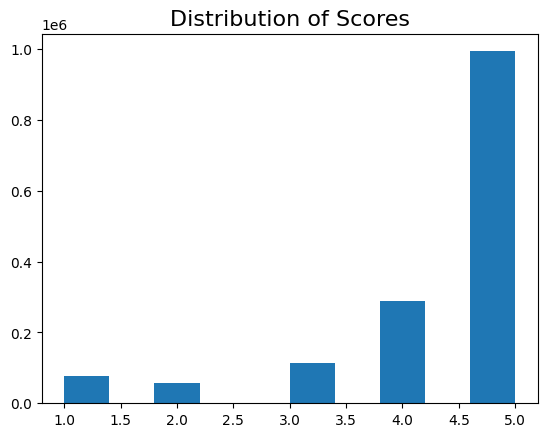

In [34]:
plt.hist(merged_df["score"].to_numpy())
plt.title("Distribution of Scores", fontsize=16)
plt.show()

In [35]:
ratings_df: pl.DataFrame = merged_df.group_by("productId").agg(
    (
        pl.col("score").len().alias("count"),
        pl.col("score").mean().round(2).alias("avg_score"),
    )
)

ratings_df.head()

productId,count,avg_score
str,u32,f32
"""B00000JAZ3""",6,4.5
"""B000001FHK""",2,5.0
"""B000002NXW""",1,3.0
"""B000QEILI8""",2,5.0
"""B0000014J1""",2,4.0


In [36]:
ratings_df.describe()

statistic,productId,count,avg_score
str,str,f64,f64
"""count""","""316706""",316706.0,316706.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,4.82832,4.401333
"""std""",null,15.514468,0.839012
"""min""","""0005224896""",1.0,1.0
"""25%""",null,1.0,4.0
"""50%""",null,2.0,4.75
"""75%""",null,3.0,5.0
"""max""","""B006B9REH6""",974.0,5.0


In [37]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.regplot(x="count", y="avg_score", data=ratings_df.to_pandas())
plt.title("Regression Plot: Count vs Average Score")
plt.xlabel("Count")
plt.ylabel("Average Score")
plt.show()

#### Comment:

- The correlation between the number of ratings and the ratings is negative.

In [ ]:
uniq_titles_df: pl.DataFrame = merged_df.select(
    ["productId", "title", "product_category"]
).drop("title")
uniq_titles_df.shape

#### Create Metadata

- Metadata: product_category + summary

In [ ]:
uniq_titles_df.head(2)

In [ ]:
product_tags_df: pl.DataFrame = merged_df.group_by("productId").agg(
    pl.col("summary").map_elements(lambda x: " ".join(x))
)
product_tags_df.head()

In [ ]:
products_df: pl.DataFrame = uniq_titles_df.join(
    product_tags_df, on="productId", how="left"
)
products_df = products_df.with_columns(
    genres=pl.col("product_category").str.replace_all(",", " ")
).with_columns(
    metadata=pl.concat_list(pl.col("summary"), pl.col("genres")).map_elements(
        lambda x: " ".join(x)
    )
)

products_df.head()

In [ ]:
products_df.select(["title", "metadata"]).head()